In [1]:
!pip install vtk
!pip install meshio

In [12]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import os
import vtkmodules.all as vtk
from vtkmodules.util.numpy_support import vtk_to_numpy, numpy_to_vtk
import meshio
from scipy.spatial.distance import cdist
from sklearn.model_selection import KFold
import random

In [13]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


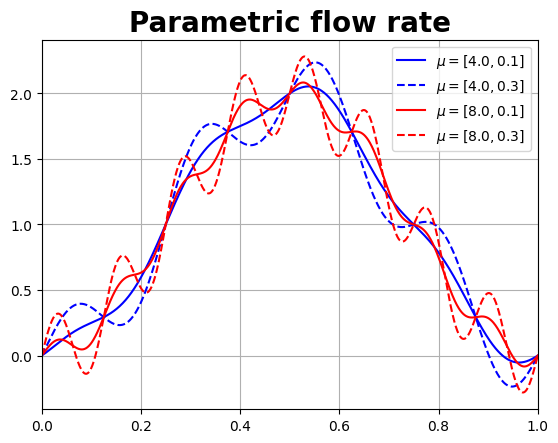

In [4]:
fields = {'velocity', 'pressure'}

basis_space, sv_space, Nh_space, nmodes_space = dict(), dict(), dict(), dict()
basis_time, sv_time, Nh_time, nmodes_time = dict(), dict(), dict(), dict()
nmodes = dict()
'/content/drive/MyDrive/dati/input_data.npy'
for field in fields:
    basis_space[field] = np.load(os.path.join('/content/drive/MyDrive/data_ML4Science', 'basis', field, 'space_basis.npy'))  # spatial basis
    sv_space[field] = np.load(os.path.join('/content/drive/MyDrive/data_ML4Science', 'basis', field, 'space_sv.npy'))  # singular values in space
    Nh_space[field], nmodes_space[field] = basis_space[field].shape  # number of FOM and ROM unknowns in space
    basis_time[field] = np.load(os.path.join('/content/drive/MyDrive/data_ML4Science', 'basis', field, 'time_basis.npy'))  # temporal basis
    sv_time[field] = np.load(os.path.join('/content/drive/MyDrive/data_ML4Science', 'basis', field, 'time_sv.npy'))  # singular values in time
    Nh_time[field], nmodes_time[field] = basis_time[field].shape  # number of FOM and ROM unknowns in time
    nmodes[field] = nmodes_space[field] * nmodes_time[field]  # total dimension of the reduced basis

# UPDATE VELOCITY BASES TO ACCOUNT FOR SUPREMIZERS AND STABILIZERS
N_supr_space = basis_space['pressure'].shape[1] + 66  # number of extra bases in space for the velocity
N_supr_time = 5  # number of extra bases in time for the velocity

# STORE ORIGINAL NUMBER OF VELOCITY MODES IN THE DICTIONARY
nmodes_space['velocity_full'] = nmodes_space['velocity']
nmodes_time['velocity_full'] = nmodes_time['velocity']
nmodes['velocity_full'] = nmodes['velocity']

# UPDATE THE NUMBER OF VELOCITY MODES TO ACCOUNT FOR SUPREMIZERS AND STABILIZERS
nmodes_space['velocity'] -= N_supr_space
nmodes_time['velocity'] -= N_supr_time
nmodes['velocity'] = nmodes_space['velocity'] * nmodes_time['velocity']

# UPDATE VELOCITY BASES TO ACCOUNT FOR SUPREMIZERS AND STABILIZERS
basis_space['velocity'] = basis_space['velocity'][:, :nmodes_space['velocity']]
basis_time['velocity'] = basis_time['velocity'][:, :nmodes_time['velocity']]

# LOAD NORMED BASIS MATRICES IN SPACE (needed for projections)
basis_space_normed = dict()
#norm = dict()
for field in fields:
    #norm[field] = load_npz(os.path.join('dataset', 'norms', f'norm_{field}.npz'))
    #basis_space_normed[field] = norm[field].dot(basis_space[field])
    #np.save(os.path.join('dataset', 'basis', field, 'basis_space_normed.npy'), basis_space_normed[field])
    basis_space_normed[field] = np.load(os.path.join('/content/drive/MyDrive/data_ML4Science', 'basis', field, 'basis_space_normed.npy'))

# n_snaps = None  # change to a number if you want to load only a subset of snapshots
# _sol = np.load(os.path.join('dataset', 'RB_data', 'solutions.npy'))[:n_snaps]
_sol = np.load(os.path.join('/content/drive/MyDrive/data_ML4Science', 'RB_data', 'solutions.npy'))

solutions = dict()

# velocity reduced solutions (with and without supremizers and stabilizers)
solutions['velocity_full'] = np.reshape(_sol[:, :nmodes['velocity_full']],
                                        (-1, nmodes_space['velocity_full'], nmodes_time['velocity_full']))
solutions['velocity'] = solutions['velocity_full'][:, :nmodes_space['velocity'], :nmodes_time['velocity']]

# pressure reduced solutions
solutions['pressure'] = np.reshape(_sol[:, :nmodes['pressure']],
                                   (-1, nmodes_space['pressure'], nmodes_time['pressure']))

##################################################################
def project(sol, normed_basis_space, basis_time):
    """ Project a full-order solution in space-time."""
    return (normed_basis_space.T.dot(sol)).dot(basis_time) # !! REMARK: here we need the normed basis in space !!

def expand(sol, basis_space, basis_time):
    """ Expand a reduced-order solution in space-time."""
    return (basis_space.dot(sol)).dot(basis_time.T)

##################################################################

params = np.load(os.path.join('/content/drive/MyDrive/data_ML4Science', 'RB_data', 'parameters.npy'))
params = np.delete(params, 2, axis=1)  # one column is useless and we delete it

Q = lambda t, mu, T=1: 1 - np.cos(2*np.pi*t/T) + mu[1] * np.sin(mu[0]*2*np.pi*t/T)

times = np.linspace(0,1,1000)
plt.plot(times, Q(times, [4.0, 0.1]), 'b-', label=r"$\mu = [4.0, 0.1]$")
plt.plot(times, Q(times, [4.0, 0.3]), 'b--', label=r"$\mu = [4.0, 0.3]$")
plt.plot(times, Q(times, [8.0, 0.1]), 'r-', label=r"$\mu = [8.0, 0.1]$")
plt.plot(times, Q(times, [8.0, 0.3]), 'r--', label=r"$\mu = [8.0, 0.3]$")

plt.grid()
plt.xlim([0,1])
plt.legend()
plt.title("Parametric flow rate", fontweight='bold', fontsize=20)
plt.show()

In [5]:
print(solutions['velocity'].shape)
print(solutions['pressure'].shape)
print(params.shape)

params = params.astype(np.float32)
solutions['velocity'] = solutions['velocity'].astype(np.float32)
solutions['pressure'] = solutions['pressure'].astype(np.float32)

(1950, 39, 16)
(1950, 9, 19)
(1950, 3)


In [6]:
device = torch.device("cuda")

class Fluid_Dataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets
    def __len__(self):
        return len(self.inputs)
    def __getitem__(self, idx):
        input_data = self.inputs[idx]
        target_data = self.targets[idx]
        return input_data, target_data

class Fluid_Dataset_auto(Dataset):
    def __init__(self, inputs):
        self.inputs = inputs
        self.targets = inputs
    def __len__(self):
        return len(self.inputs)
    def __getitem__(self, idx):
        input_data = self.inputs[idx]
        target_data = self.targets[idx]
        return input_data, target_data

N_data=params.shape[0]
indices = torch.randperm(N_data)
ratio_data=0.8
train_size = int(ratio_data * N_data)
train_indices = indices[:train_size]
test_indices=indices[train_size:]

mean_params=np.mean(params,axis=0)
min_params=np.min(params,axis=0)
max_params=np.max(params,axis=0)
std_params=np.std(params,axis=0)
params_norm=(params-mean_params)/std_params
# params_norm=(params-min_params)/(max_params-min_params)
#FARE IN -1,1??

train_params=params_norm[train_indices]
test_params=params_norm[test_indices]

vel=solutions['velocity']
# max_vel=np.max(vel,axis=0)
# min_vel=np.min(vel,axis=0)
# # print(min_vel.shape)
# vel=(vel-min_vel)/(max_vel-min_vel)
# mean_vel=np.mean(vel,axis=0)
# std_vel=np.std(vel,axis=0)
# vel=(vel-mean_vel)/std_vel

train_vel=vel[train_indices]
test_vel=vel[test_indices]

train_press=solutions['pressure'][train_indices]
test_press=solutions['pressure'][test_indices]
# dataset = Fluid_Dataset(params_norm, solutions['velocity'])

# dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2)

print(test_vel.shape,train_vel.shape)


(390, 39, 16) (1560, 39, 16)


In [7]:
K=256
class MLP_vel_model(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.gelu = torch.nn.GELU()
        self.ln = torch.nn.LayerNorm(K)

        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(3,K),
            torch.nn.LayerNorm(K),
            torch.nn.GELU(),
            torch.nn.Linear(K,K),
            torch.nn.LayerNorm(K),
            torch.nn.GELU(),
            torch.nn.Linear(K,K),
            torch.nn.LayerNorm(K),
            torch.nn.GELU(),
            torch.nn.Linear(K,K),
            torch.nn.LayerNorm(K),
            torch.nn.GELU(),
            torch.nn.Linear(K,K),
            torch.nn.LayerNorm(K),
            torch.nn.GELU(),
            torch.nn.Linear(K,39*16)
        )


    def forward(self, Z):
        Z = torch.flatten(Z, 1)
        Z = self.mlp(Z)
        Z = Z.view(-1, 39, 16)
        return Z

class Autoencoder(torch.nn.Module):
    def __init__(self): #VARIARE NUMERO LAYER E NH es (Nh=32)
        super(Autoencoder, self).__init__()

        self.encoder = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(39 * 16, 512),  # Livello completamente connesso
            torch.nn.LayerNorm(512),
            torch.nn.ReLU()
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.LayerNorm(512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 39 * 16),  # Ricostruisce la dimensione piatta
            torch.nn.Unflatten(1, (39, 16))
        )
                                     # Normalizza l'output [0,1])
    def forward(self, x):
        Z = torch.flatten(x, 1)
        Z1=self.encoder(Z)
        Z2=self.decoder(Z1)
        return Z2

class Autoencoder2(torch.nn.Module):
    def __init__(self): #VARIARE NUMERO LAYER E NH es (Nh=32)
        super(Autoencoder2, self).__init__()


        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 64, kernel_size=5, stride=2, padding=1),  # (1, 39, 16) -> (64, 19, 7)
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), # (64, 19, 7) -> (128, 10, 4)
            torch.nn.ReLU(),
            torch.nn.Flatten(),                                          # (32, 10, 4) -> (32*10*4)
            torch.nn.Linear(128*10*4, 256)                               # Bottleneck
            # torch.nn.ReLU(),
            # torch.nn.Linear(128, 32)                                     # Latent space
        )


        # Decoder
        self.decoder = torch.nn.Sequential(
            # torch.nn.Linear(32, 128),
            # torch.nn.ReLU(),
            torch.nn.Linear(256, 128*10*4),
            torch.nn.ReLU(),
            torch.nn.Unflatten(1, (128, 10, 4)),                         # (32*10*4) -> (32, 10, 4)
            torch.nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=(0, 0)), #(64,19,7)
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(64, 1, kernel_size=5, stride=2, padding=1, output_padding=(0, 1)),   # -> (1, 39, 16)
            # torch.nn.Sigmoid()                                          # Normalizza l'output [0,1]
        )
                                     # Normalizza l'output [0,1])
    def forward(self, x):
        x=x.unsqueeze(1)
        Z1=self.encoder(x)
        Z2=self.decoder(Z1)
        Z2=Z2.squeeze(1)
        return Z2

class MLP_vel_ConvAutoencoder(torch.nn.Module):
    def __init__(self): #VARIARE NUMERO LAYER E NH es (Nh=32)
        super(MLP_vel_ConvAutoencoder, self).__init__()

        self.gelu = torch.nn.GELU()
        self.ln = torch.nn.LayerNorm(256)

        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(3,256),
            torch.nn.LayerNorm(256),
            torch.nn.GELU(),
            torch.nn.Linear(256,256),
            torch.nn.LayerNorm(256),
            torch.nn.GELU(),
            torch.nn.Linear(256,256),
            torch.nn.LayerNorm(256),
            torch.nn.GELU(),
            torch.nn.Linear(256,256),
            torch.nn.LayerNorm(256),
            torch.nn.GELU(),
            torch.nn.Linear(256,256),
            torch.nn.LayerNorm(256),
            torch.nn.GELU(),
            torch.nn.Linear(256,128)
        )

        # self.encoder = torch.nn.Sequential(
        #     torch.nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # (1, 39, 16) -> (16, 20, 8)
        #     torch.nn.GELU(),
        #     torch.nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), # (16, 20, 8) -> (32, 10, 4)
        #     torch.nn.GELU(),
        #     torch.nn.Flatten(),                                          # (32, 10, 4) -> (32*10*4)
        #     torch.nn.Linear(32*10*4, 128),                               # Bottleneck
        #     torch.nn.GELU(),
        #     torch.nn.Linear(128, 64)                                     # Latent space
        # )

        # self.encoder = torch.nn.Sequential(
        #     torch.nn.Flatten(),
        #     torch.nn.Linear(39 * 16, 512),  # Livello completamente connesso
        #     torch.nn.LayerNorm(512),
        #     torch.nn.ReLU(),
        #     torch.nn.Linear(512, 256),
        #     torch.nn.LayerNorm(256),
        #     torch.nn.ReLU(),
        #     torch.nn.Linear(256, 256)
        # )

        # self.decoder = torch.nn.Sequential(
        #     torch.nn.Linear(256, 256),
        #     torch.nn.LayerNorm(256),
        #     torch.nn.ReLU(),
        #     torch.nn.Linear(256, 512),
        #     torch.nn.LayerNorm(512),
        #     torch.nn.ReLU(),
        #     torch.nn.Linear(512, 39 * 16),  # Ricostruisce la dimensione piatta
        #     torch.nn.Unflatten(1, (39, 16))
        # )

        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 64, kernel_size=5, stride=2, padding=1),  # (1, 39, 16) -> (64, 19, 7)
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), # (64, 19, 7) -> (128, 10, 4)
            torch.nn.ReLU(),
            torch.nn.Flatten(),                                          # (32, 10, 4) -> (32*10*4)
            torch.nn.Linear(128*10*4, 256),                               # Bottleneck
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128)                                     # Latent space
        )


        # Decoder
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(128, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128*10*4),
            torch.nn.ReLU(),
            torch.nn.Unflatten(1, (128, 10, 4)),                         # (32*10*4) -> (32, 10, 4)
            torch.nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=(0, 0)), #(64,19,7)
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(64, 1, kernel_size=5, stride=2, padding=1, output_padding=(0, 1)),   # -> (1, 39, 16)
            # torch.nn.Sigmoid()                                          # Normalizza l'output [0,1]
        )

        # # Decoder
        # self.decoder = torch.nn.Sequential(
        #     torch.nn.Linear(64, 128),
        #     torch.nn.GELU(),
        #     torch.nn.Linear(128, 32*10*4),
        #     torch.nn.GELU(),
        #     torch.nn.Unflatten(1, (32, 10, 4)),                         # (32*10*4) -> (32, 10, 4)
        #     torch.nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=(1, 1)), #(16,20,8)
        #     torch.nn.GELU(),
        #     torch.nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=(0, 1)))   # -> (1, 39, 16)
        #    # torch.nn.Sigmoid()  )                                        # Normalizza l'output [0,1])
    def forward(self, x, y):
        # Z = torch.flatten(x, 1)
        Z=x
        Z1 = self.mlp(Z)

        y = y.unsqueeze(1)
        Z2=self.encoder(y)
        Z3=self.decoder(Z2)
        Z3=Z3.squeeze(1)
        return Z1, Z2, Z3

    def predict(self, x):
        # Z = torch.flatten(x, 1)
        Z=x
        Z1 = self.mlp(Z)

        Z2=self.decoder(Z1)
        Z2=Z2.squeeze(1)
        return Z2



In [8]:
def train_epoch(model, device, train_loader, optimizer, scheduler, epoch, criterion):
    model.train()  # Important set model to train mode (affects dropout, batch norm etc)

    loss_history = []
    accuracy_history = []
    for batch_idx, (data, target) in enumerate(train_loader):

        data=data.to(device)
        target=target.to(device)
        output = model.forward(data)  # TODO
        loss =  criterion(output, target)

        optimizer.zero_grad()  # Zero the gradients
        loss.backward()        # Backpropagation
        optimizer.step()       # Update the weights
        scheduler.step()

        loss_history.append(loss.item())

        if batch_idx % (len(train_loader.dataset) // len(data) // 4) == 0:
            print(
                f"Train Epoch: {epoch}-{batch_idx} batch_loss={loss.item()/len(data):0.2e}"
            )

    return loss_history

def train_epoch_conv(model, device, train_loader, optimizer, epoch, criterion,scheduler):
  model.train()  # Important set model to train mode (affects dropout, batch norm etc)

  loss_history = []
  accuracy_history = []
  for batch_idx, (data, target) in enumerate(train_loader):

      data=data.to(device)
      target=target.to(device)
      Z1,Z2,Z3 = model.forward(data,target)
      # print(Z1.shape,Z2.shape,Z3.shape)
      loss =  0.5* criterion(Z1, Z2)+ 0.5* criterion(target, Z3)

      optimizer.zero_grad()  # Zero the gradients
      loss.backward()        # Backpropagation
      optimizer.step()       # Update the weights

      scheduler.step()

      loss_history.append(loss.item())

      if batch_idx % (len(train_loader.dataset) // len(data) // 4) == 0:
          print(
              f"Train Epoch: {epoch}-{batch_idx} batch_loss={loss.item()/len(data):0.2e}"
          )

  return loss_history



@torch.no_grad()
def validate(model, device, val_loader, criterion):
    model.eval()  # Important set model to eval mode (affects dropout, batch norm etc)
    test_loss = 0
    test_rel_loss = 0
    for data, target in val_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += criterion(output, target).item() * len(data)
        # test_rel_loss += criterion(output, target).item()/torch.norm(target).item() * len(data)
        test_rel_loss += ((torch.norm((output-target).view(output.shape[0], -1), dim=1)/torch.norm((target).view(output.shape[0],-1), dim=1)).sum()).item()

    test_loss /= len(val_loader.dataset)
    test_rel_loss /= len(val_loader.dataset)

    print(
        "Test set: Average loss: {:.4f} Average relative error: {:.4f}".format(
            test_loss, test_rel_loss
        )
    )
    return test_loss,test_rel_loss

@torch.no_grad()
def validate_conv(model, device, val_loader, criterion):
    model.eval()  # Important set model to eval mode (affects dropout, batch norm etc)
    test_loss = 0
    test_rel_loss = 0
    for data, target in val_loader:
        data, target = data.to(device), target.to(device)
        output = model.predict(data)
        Z1,Z2,Z3 = model.forward(data,target)
        test_loss +=  (0.5* criterion(Z1, Z2).item()+ 0.5* criterion(target, Z3).item()) * len(data)
        test_rel_loss += ((torch.norm((output-target).view(output.shape[0], -1), dim=1)/torch.norm((target).view(output.shape[0],-1), dim=1)).sum()).item()

    test_loss /= len(val_loader.dataset)
    test_rel_loss /= len(val_loader.dataset)

    print(
        "Test set: Average loss: {:.4f} Average relative error: {:.4f}".format(
            test_loss, test_rel_loss
        )
    )
    return test_loss,test_rel_loss


# def run_vel_training(num_epochs, lr, batch_size, device="cuda"):

#     train_set = Fluid_Dataset(train_params, train_vel)

#     val_set = Fluid_Dataset(test_params, test_vel)

#     train_loader = torch.utils.data.DataLoader(
#         train_set,
#         batch_size=batch_size,
#         shuffle=True,  # Can be important for training
#         pin_memory=torch.cuda.is_available(),
#         drop_last=True,
#         num_workers=2,
#     )
#     val_loader = torch.utils.data.DataLoader(
#         val_set,
#         batch_size=batch_size,
#     )

#     # ===== Model, Optimizer and Criterion =====
#     model = MLP_vel_model()
#     model = model.to(device=device)
#     optimizer = torch.optim.SGD(
#         model.parameters(),
#         lr=lr,
#         weight_decay=1e-4
#     )
#     criterion = torch.nn.functional.mse_loss

#     # ===== Train Model =====
#     train_loss_history = []
#     val_loss_history = []
#     val_rel_loss_history = []

#     for epoch in range(1, num_epochs + 1):
#         train_loss = train_epoch(
#             model, device, train_loader, optimizer, epoch, criterion
#         )
#         train_loss_history.extend(train_loss)

#         val_loss,val_rel_loss= validate(model, device, val_loader, criterion)
#         val_loss_history.append(val_loss)
#         val_rel_loss_history.append(val_rel_loss)

#     # ===== Plot training curves =====
#     n_train = len(train_loss_history)
#     t_train = num_epochs * np.arange(n_train) / n_train
#     t_val = np.arange(1, num_epochs + 1)

#     plt.figure()
#     plt.plot(t_train, train_loss_history, label="Train")
#     plt.plot(t_val, val_loss_history, label="Val")
#     plt.legend()
#     plt.xlabel("Epoch")
#     plt.ylabel("Loss")

#     plt.figure()
#     plt.plot(t_val, val_rel_loss_history, label="Val rel err")
#     plt.legend()
#     plt.xlabel("Epoch")
#     plt.ylabel("rel err")

    return model

def run_training(model,train_output,test_output,num_epochs, lr, batch_size, device="cuda"):

  train_set = Fluid_Dataset(train_params, train_output)

  val_set = Fluid_Dataset(test_params, test_output)

  train_loader = torch.utils.data.DataLoader(
      train_set,
      batch_size=batch_size,
      shuffle=True,  # Can be important for training
      pin_memory=torch.cuda.is_available(),
      drop_last=True,
      num_workers=2,
  )
  val_loader = torch.utils.data.DataLoader(
      val_set,
      batch_size=batch_size,
  )

  # ===== Model, Optimizer and Criterion =====
  model = model.to(device=device)
  optimizer = torch.optim.Adam(
      model.parameters(),
      lr=lr,
  )

  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.99)

  criterion = torch.nn.functional.mse_loss

  # ===== Train Model =====
  train_loss_history = []
  val_loss_history = []
  val_rel_loss_history = []

  for epoch in range(1, num_epochs + 1):
      train_loss = train_epoch(
          model, device, train_loader, optimizer, scheduler, epoch, criterion
      )
      train_loss_history.extend(train_loss)

      val_loss,val_rel_loss= validate(model, device, val_loader, criterion)
      val_loss_history.append(val_loss)
      val_rel_loss_history.append(val_rel_loss)

  # ===== Plot training curves =====
  n_train = len(train_loss_history)
  t_train = num_epochs * np.arange(n_train) / n_train
  t_val = np.arange(1, num_epochs + 1)

  plt.figure()
  plt.plot(t_train, train_loss_history, label="Train")
  plt.plot(t_val, val_loss_history, label="Val")
  plt.legend()
  plt.xlabel("Epoch")
  plt.ylabel("Loss")

  plt.figure()
  plt.plot(t_val, val_rel_loss_history, label="Val rel err")
  plt.legend()
  plt.xlabel("Epoch")
  plt.ylabel("rel err")

  return model

def run_training_auto(model,train_output,test_output,num_epochs, lr, batch_size, device="cuda"):

  train_set = Fluid_Dataset_auto(train_output)

  val_set = Fluid_Dataset_auto(test_output)

  train_loader = torch.utils.data.DataLoader(
      train_set,
      batch_size=batch_size,
      shuffle=True,  # Can be important for training
      pin_memory=torch.cuda.is_available(),
      drop_last=True,
      num_workers=2,
  )
  val_loader = torch.utils.data.DataLoader(
      val_set,
      batch_size=batch_size,
  )

  # ===== Model, Optimizer and Criterion =====
  model = model.to(device=device)
  optimizer = torch.optim.Adam(
      model.parameters(),
      lr=lr,
  )

  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.99)

  criterion = torch.nn.functional.mse_loss

  # ===== Train Model =====
  train_loss_history = []
  val_loss_history = []
  val_rel_loss_history = []

  for epoch in range(1, num_epochs + 1):
      train_loss = train_epoch(
          model, device, train_loader, optimizer, scheduler, epoch, criterion
      )
      train_loss_history.extend(train_loss)

      val_loss,val_rel_loss= validate(model, device, val_loader, criterion)
      val_loss_history.append(val_loss)
      val_rel_loss_history.append(val_rel_loss)

  # ===== Plot training curves =====
  n_train = len(train_loss_history)
  t_train = num_epochs * np.arange(n_train) / n_train
  t_val = np.arange(1, num_epochs + 1)

  plt.figure()
  plt.plot(t_train, train_loss_history, label="Train")
  plt.plot(t_val, val_loss_history, label="Val")
  plt.legend()
  plt.xlabel("Epoch")
  plt.ylabel("Loss")

  plt.figure()
  plt.plot(t_val, val_rel_loss_history, label="Val rel err")
  plt.legend()
  plt.xlabel("Epoch")
  plt.ylabel("rel err")

  return model

def run_training_conv(model,train_output,test_output,num_epochs, lr, batch_size, wd, device="cuda"):

  train_set = Fluid_Dataset(train_params, train_output)

  val_set = Fluid_Dataset(test_params, test_output)

  train_loader = torch.utils.data.DataLoader(
      train_set,
      batch_size=batch_size,
      shuffle=True,  # Can be important for training
      pin_memory=torch.cuda.is_available(),
      drop_last=True,
      num_workers=2,
  )
  val_loader = torch.utils.data.DataLoader(
      val_set,
      batch_size=batch_size,
  )

  # ===== Model, Optimizer and Criterion =====
  model = model.to(device=device)
  optimizer = torch.optim.Adam(
      model.parameters(),
      lr=lr,
      weight_decay=wd
  )

  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.99)

  criterion = torch.nn.functional.mse_loss

  # ===== Train Model =====
  train_loss_history = []
  val_loss_history = []
  val_rel_loss_history = []

  for epoch in range(1, num_epochs + 1):
      train_loss = train_epoch_conv(
          model, device, train_loader, optimizer, epoch, criterion,scheduler
      )
      train_loss_history.extend(train_loss)

      val_loss, val_rel_loss= validate_conv(model, device, val_loader, criterion)
      val_loss_history.append(val_loss)
      val_rel_loss_history.append(val_loss)

  # ===== Plot training curves =====
  n_train = len(train_loss_history)
  t_train = num_epochs * np.arange(n_train) / n_train
  t_val = np.arange(1, num_epochs + 1)

  plt.figure()
  plt.plot(t_train, train_loss_history, label="Train")
  plt.plot(t_val, val_loss_history, label="Val")
  plt.legend()
  plt.xlabel("Epoch")
  plt.ylabel("Loss")

  plt.figure()
  plt.plot(t_val, val_rel_loss_history, label="Val rel err")
  plt.legend()
  plt.xlabel("Epoch")
  plt.ylabel("rel err")


  return model



In [11]:
# lr = 0.01
# batch_size = 32
# num_epochs = 500
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model_vel_trained=run_training(MLP_vel_model(), train_vel, test_vel, num_epochs, lr, batch_size, device)


lr = 0.0001
batch_size = 32
num_epochs = 500
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
wd=1e-3

model_vel_trained_autoencoder=run_training_conv(MLP_vel_ConvAutoencoder(), train_vel, test_vel, num_epochs, lr, batch_size, wd, device)

# lr = 0.0005
# batch_size = 32
# num_epochs = 200
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# wd=1e-3

# model_vel_trained_autoencoder=run_training_auto(Autoencoder(), train_vel, test_vel, num_epochs, lr, batch_size, device)

Train Epoch: 1-0 batch_loss=8.36e-01
Train Epoch: 1-12 batch_loss=8.21e-01
Train Epoch: 1-24 batch_loss=8.28e-01
Train Epoch: 1-36 batch_loss=8.28e-01
Test set: Average loss: 25.6492 Average relative error: 0.9883
Train Epoch: 2-0 batch_loss=7.86e-01
Train Epoch: 2-12 batch_loss=7.68e-01
Train Epoch: 2-24 batch_loss=7.26e-01
Train Epoch: 2-36 batch_loss=6.60e-01
Test set: Average loss: 18.5284 Average relative error: 0.8811
Train Epoch: 3-0 batch_loss=5.78e-01
Train Epoch: 3-12 batch_loss=5.06e-01
Train Epoch: 3-24 batch_loss=4.35e-01
Train Epoch: 3-36 batch_loss=3.69e-01
Test set: Average loss: 9.0505 Average relative error: 0.6752
Train Epoch: 4-0 batch_loss=2.75e-01
Train Epoch: 4-12 batch_loss=1.96e-01
Train Epoch: 4-24 batch_loss=1.24e-01
Train Epoch: 4-36 batch_loss=1.02e-01
Test set: Average loss: 2.6143 Average relative error: 0.3677
Train Epoch: 5-0 batch_loss=7.69e-02
Train Epoch: 5-12 batch_loss=7.91e-02
Train Epoch: 5-24 batch_loss=7.61e-02
Train Epoch: 5-36 batch_loss=5.89

KeyboardInterrupt: 

In [ ]:
print(lr)

In [ ]:
def read_vtk(filename):
    """Read .vtk file and return the polydata"""

    fn_dir, fn_ext = os.path.splitext(filename)

    if fn_ext == '.vtk':
        reader = vtk.vtkPolyDataReader()
    elif fn_ext == '.vtp':
        reader = vtk.vtkXMLPolyDataReader()
    elif fn_ext == '.stl':
        reader = vtk.vtkSTLReader()
    elif fn_ext == '.obj':
        reader = vtk.vtkOBJReader()
    elif fn_ext == '.vtu':
        reader = vtk.vtkXMLUnstructuredGridReader()
    elif fn_ext == '.pvtu':
        reader = vtk.vtkXMLPUnstructuredGridReader()
    else:
        raise ValueError(F"File extension {fn_ext} not supported")

    reader.SetFileName(filename)
    reader.Update(0)
    mesh = reader.GetOutput()

    return mesh

def write_vtk(mesh, fn):
    """ Write a mesh (vtk polydata or unstructured grid) to disk """

    _, extension = os.path.splitext(fn)

    if extension == '.vtk':
        writer = vtk.vtkPolyDataWriter()
    elif extension == '.stl':
        writer = vtk.vtkSTLWriter()
    elif extension == '.vtp':
        writer = vtk.vtkXMLPolyDataWriter()
    elif extension == '.vtu':
        writer = vtk.vtkXMLUnstructuredGridWriter()
    elif extension == '.obj':
        writer = vtk.vtkOBJWriter()
    else:
        raise ValueError(f"Unrecognized extension {extension}")

    writer.SetInputData(mesh)
    writer.SetFileName(fn)
    writer.Update(0)
    writer.Write()

    return

def add_array(mesh, array, name):
    """Add numpy array as new field to a vtk file"""

    new_array = numpy_to_vtk(array)
    new_array.SetName(name)
    mesh.GetPointData().AddArray(new_array)

    return mesh

def compute_matching_idxs():
    """Compute correspondences bewteen indices on the .vtu and on the .mesh file for plotting"""

    mesh = read_vtk(os.path.join('/content/drive/MyDrive/data_ML4Science', 'geometries', 'bif_sym_alpha50_h0.10_ref.vtu'))
    points = vtk_to_numpy(mesh.GetPoints().GetData())

    mesh_2 = meshio.read(os.path.join('/content/drive/MyDrive/data_ML4Science', 'geometries','bif_sym_alpha50_h0.10.mesh'))
    points_2 = mesh_2.points

    dist = cdist(mesh_2.points, points, metric='euclidean')

    idxs = np.argmin(dist, axis=0)

    return idxs


def visualize_solution(fields_array, fields=None, step_t=10):
    """ Export the solution corresponding to the n-th snapshot (every step_t steps) to a .vtu file."""

    if fields is None:
        fields = {'velocity': 3, 'pressure': 1}  # fields and corresponding dimensions

    os.makedirs('solutions', exist_ok=True)

    idxs = compute_matching_idxs()

    mesh = read_vtk(os.path.join('/content/drive/MyDrive/data_ML4Science', 'geometries', 'bif_sym_alpha50_h0.10.vtu'))

    fom_solution = dict()
    for field in fields:
        # print(f"Processing field {field} - Dimension: {fields[field]}")
        cur_idxs = np.hstack([idxs + k * (Nh_space[field]//fields[field]) for k in range(fields[field])])
        fom_solution[field] = expand(fields_array[field], basis_space[field], basis_time[field])[cur_idxs]
        print(fom_solution[field].shape)

    for cnt_t in range(0, Nh_time['velocity'], step_t):
        # print(f"\nProcessing timestep {cnt_t} of {Nh_time['velocity']}")
        for field in fields:
            cur_fom_solution = np.reshape(fom_solution[field][:, cnt_t], (fields[field], -1)).T
            mesh = add_array(mesh, cur_fom_solution, field)

        # write_vtk(mesh, os.path.join('solutions', f"solution_{n}_{cnt_t}" + '.vtu'))
        write_vtk(mesh, os.path.join('solutions', f"solution_{cnt_t}" + '.vtu'))

    return


In [ ]:
# model_vel_trained.eval()
# model_press_trained.eval()
model_vel_trained_autoencoder.eval()
model_press_trained_autoencoder.eval()

input_tensor = torch.tensor(test_params[0,:], dtype=torch.float32)  # Trasforma in tensore
input_tensor = input_tensor.unsqueeze(dim=0)
input_tensor = input_tensor.to(device)

with torch.no_grad():
    # output_vel_visual = model_vel_trained(input_tensor)
    # output_vel_visual=output_vel_visual[0]
    # print(output_vel_visual.shape)
    # output_press_visual = model_press_trained(input_tensor)
    # output_press_visual=output_press_visual[0]
    # print(output_press_visual.shape)
    output_vel_visual = model_vel_trained_autoencoder.predict(input_tensor)
    output_vel_visual=output_vel_visual[0]
    print(output_vel_visual.shape)
    output_press_visual = model_press_trained_autoencoder.predict(input_tensor)
    output_press_visual=output_press_visual[0]
    print(output_press_visual.shape)

output_visual=dict()
output_visual['velocity']=output_vel_visual.cpu().numpy()
output_visual['pressure']=output_press_visual.cpu().numpy()
visualize_solution(output_visual,step_t=5)

torch.Size([39, 16])
torch.Size([9, 19])
(10656, 1000)
(3552, 1000)


In [ ]:
!zip -r solutions.zip solutions
from google.colab import files
files.download('solutions.zip')

  adding: solutions/ (stored 0%)
  adding: solutions/solution_285.vtu (deflated 29%)
  adding: solutions/solution_565.vtu (deflated 29%)
  adding: solutions/solution_535.vtu (deflated 29%)
  adding: solutions/solution_295.vtu (deflated 29%)
  adding: solutions/solution_410.vtu (deflated 29%)
  adding: solutions/solution_855.vtu (deflated 29%)
  adding: solutions/solution_945.vtu (deflated 29%)
  adding: solutions/solution_590.vtu (deflated 29%)
  adding: solutions/solution_805.vtu (deflated 29%)
  adding: solutions/solution_820.vtu (deflated 29%)
  adding: solutions/solution_650.vtu (deflated 29%)
  adding: solutions/solution_940.vtu (deflated 29%)
  adding: solutions/solution_110.vtu (deflated 29%)
  adding: solutions/solution_595.vtu (deflated 29%)
  adding: solutions/solution_635.vtu (deflated 29%)
  adding: solutions/solution_340.vtu (deflated 29%)
  adding: solutions/solution_985.vtu (deflated 29%)
  adding: solutions/solution_55.vtu (deflated 29%)
  adding: solutions/solution_365

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>